## Predicting

**Importing librairies**


In [127]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
import geopandas as gpd
from tqdm import tqdm

**Denne nettsiden snakker litt om hvordan jobbe med ubalanserte datasett**

https://medium.com/digital-catapult/dealing-with-imbalanced-data-8b21e6deb6cd

**Importing data**

In [567]:
Filename = "data\_tarefelt1.csv"
data = pd.read_csv(Filename)


In [556]:
Filename = "data\_tarefelt2.csv"
data2 = pd.read_csv(Filename)

In [557]:
data2.columns

Index(['Unnamed: 0', 'band_0', 'band_1', 'band_2', 'band_3', 'band_4',
       'band_5', 'band_6', 'band_7', 'band_8', 'band_9', 'band_10', 'band_11',
       'band_12', 'band_13', 'band_14', 'band_15', 'band_16', 'band_17',
       'band_18', 'band_19', 'band_20', 'band_21', 'band_22', 'band_23',
       'band_24', 'band_25', 'band_26', 'band_27', 'band_28', 'band_29',
       'band_30', 'band_31', 'band_32', 'band_33', 'band_34', 'band_35',
       'band_36', 'band_37', 'band_38', 'band_39', 'band_40', 'band_41',
       'band_42', 'band_43', 'band_44', 'band_45', 'band_46', 'band_47',
       'band_48', 'band_49', 'band_50', 'band_51', 'band_52', 'band_53',
       'band_54', 'band_55', 'band_56', 'band_57', 'band_58', 'band_59',
       'band_60', 'band_61', 'band_62', 'band_63', 'band_64', 'band_65', 'lat',
       'lon', 'geometry', 'label'],
      dtype='object')

In [568]:
#Removes 90% of data labeled 0
data = data.drop(data[data['label'] == 0].sample(frac=.95).index)

In [575]:
data_x = data.drop(["Unnamed: 0"], axis=1)
data_x = data_x.drop(["label"], axis=1)
data_x = data_x.drop(columns = "geometry")
data_y = data.label

**Scale dataset**

In [576]:
""" scaler = StandardScaler()
scaler.fit(data_x) 
scaled_data_x = scaler.transform(data_x)

print(scaled_data_x.shape)
data_x = pd.DataFrame(scaled_data_x, index= data_x.index, columns=data_x.columns)
data_x.lat
 """

' scaler = StandardScaler()\nscaler.fit(data_x) \nscaled_data_x = scaler.transform(data_x)\n\nprint(scaled_data_x.shape)\ndata_x = pd.DataFrame(scaled_data_x, index= data_x.index, columns=data_x.columns)\ndata_x.lat\n '

In [585]:
scalable_columns = list(data_x.columns)
scalable_columns.remove("lat")
scalable_columns.remove("lon")

temp = data_x.drop(["lat"], axis=1)
temp = temp.drop(["lon"], axis=1)

scaler = StandardScaler()
scaler.fit(temp) 
scaled_data_x = scaler.transform(temp)

scaled_data_x_df = pd.DataFrame(scaled_data_x, index= data_x.index, columns=scalable_columns)
scaled_data_x_df["lon"] = data_x.lon
scaled_data_x_df["lat"] = data_x.lat

data_x = scaled_data_x_df

**Splitting Data**

In [586]:
X_train, X_test ,y_train, y_test = train_test_split( data_x, data_y, test_size=0.30, random_state=42)
X_test, X_val ,y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

**Definerer en batch generator**

In [587]:
def batch(iterable_X, iterable_y, n=1):
    '''
    n: batchsize
    iterable_X: X frame to be iterated over
    iterable_y: y frame to be iterated over
    '''
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]


In [588]:
""" scaler = StandardScaler()
scaler.fit(X_train) 
scaled_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(scaled_X_train, index= X_train.index, columns=X_train.columns)
scaled_X_test = scaler.transform(X_test)
X_test  = pd.DataFrame(scaled_X_test, index= X_test.index, columns=X_test.columns)
scaled_X_val = scaler.transform(X_val)
X_val  = pd.DataFrame(scaled_X_val, index= X_val.index, columns=X_val.columns) """

' scaler = StandardScaler()\nscaler.fit(X_train) \nscaled_X_train = scaler.transform(X_train)\nX_train = pd.DataFrame(scaled_X_train, index= X_train.index, columns=X_train.columns)\nscaled_X_test = scaler.transform(X_test)\nX_test  = pd.DataFrame(scaled_X_test, index= X_test.index, columns=X_test.columns)\nscaled_X_val = scaler.transform(X_val)\nX_val  = pd.DataFrame(scaled_X_val, index= X_val.index, columns=X_val.columns) '

**Training the model**  


In [607]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(max_iter=1000, tol=1e-3, class_weight= dict(zip(np.unique(y_train), class_weights)))


classes = np.unique(y_train)
accuracy =[]
ROUNDS = 2000
batch_size = 10000
for _ in tqdm(range(ROUNDS), total=ROUNDS):
    #X_train, y_train = shuffle(X_train, y_train)
    batcherator = batch(X_train, y_train, batch_size)
    
    for index, (X, target) in enumerate(batcherator):

        #scaler = StandardScaler()
        #scaler.fit(X) 
        #X = scaler.transform(X)
        #test = scaler.transform(X_val) 
        clf.partial_fit(X, target, classes)
        y_predicted = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_predicted))

100%|██████████| 2000/2000 [05:02<00:00,  6.62it/s]


**Evaluating Model**


[[5340 1724]
 [1022 7072]]


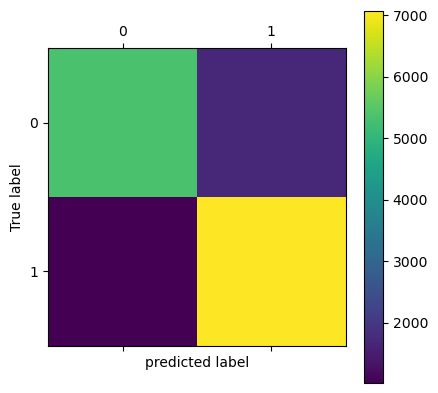

In [608]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)

print(conf_mat)
# Plot matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

**Checking over the test set**

In [609]:
y_predicted = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_predicted)
print(f"The accuracy of the model was {np.round(accuracy,2)}")

The accuracy of the model was 0.81


In [610]:
y_predicted == y_val
X_val

,band_0,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,...,band_58,band_59,band_60,band_61,band_62,band_63,band_64,band_65,lon,lat
127057,0.0,0.0,0.0,-0.386013,-0.357872,-0.354419,-0.409512,-0.427390,-0.415655,-0.394437,...,-1.315540,-0.741625,-1.311076,-0.897652,-1.761371,-1.498594,-0.494374,-1.330873,5.054610,62.054936
924992,0.0,0.0,0.0,-0.301704,-0.267042,-0.294122,-0.243286,-0.242300,-0.241587,-0.250967,...,-0.059860,0.112475,0.368921,0.225058,0.242460,1.431173,1.631339,0.756258,4.445301,61.887454
276732,0.0,0.0,0.0,-0.247570,-0.282181,-0.176095,-0.256996,-0.219570,-0.259179,-0.252685,...,-0.056774,0.560877,0.974005,0.255923,0.432414,1.083284,-0.250440,-0.139560,4.846259,61.896789
619097,0.0,0.0,0.0,-0.353177,-0.355853,-0.290274,-0.334111,-0.375435,-0.376768,-0.378973,...,-1.611720,-0.981247,-1.079720,-1.649983,-1.567692,-1.911285,-2.184489,-0.789650,4.779899,62.087761
253157,0.0,0.0,0.0,4.152435,4.177547,4.107516,4.169397,4.178743,4.136964,4.096080,...,1.078583,0.850322,1.365530,0.032152,-0.319954,-0.407179,-0.950879,-0.649678,4.967311,62.040585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85920,0.0,0.0,0.0,-0.272418,-0.328605,-0.348004,-0.274132,-0.299126,-0.291586,-0.294781,...,0.119083,0.342607,0.062820,0.371666,0.451037,1.137855,1.387404,0.821578,4.914477,61.832439
519008,0.0,0.0,0.0,-0.457896,-0.429526,-0.414715,-0.445499,-0.484215,-0.473987,-0.459728,...,-1.799918,-1.185282,-1.353788,-1.387632,-2.442972,-2.187549,-1.389961,-0.839418,4.851003,62.101594
543248,0.0,0.0,0.0,-0.206747,-0.240803,-0.204319,-0.238145,-0.200087,-0.236958,-0.231208,...,-0.220291,0.053162,0.119769,-0.199334,-0.487560,-0.601587,-0.731338,-0.204880,4.792658,62.042834
544293,0.0,0.0,0.0,-0.218283,-0.215572,-0.254352,-0.241573,-0.229311,-0.239736,-0.247531,...,-0.115393,0.095867,-0.182773,0.043727,-0.245462,0.012334,0.781054,0.062621,4.783618,62.031513


In [611]:
unique, counts = np.unique(y_predicted, return_counts=True)
print(unique)
print(counts)

[0. 1.]
[6314 8844]


In [612]:
y_test.value_counts()


1.0    8094
0.0    7064
Name: label, dtype: int64

**Plotting the predicted seaweed and comparing with naturdirektoratet**

In [613]:
X = X_val.copy()
X["label"] = y_val
X["y_predicted"] = y_predicted
X = gpd.GeoDataFrame(X, geometry=gpd.points_from_xy(X.lon, X.lat))



df_no_seaweed = X[X["y_predicted"] == False]
df_seaweed = X[X["y_predicted"] == 1]
df_true_seaweed = X[X["label"] == True]
df_correct_prediction = X[X["label"] == X["y_predicted"]]
df_correct_prediction = df_correct_prediction[df_correct_prediction["y_predicted"] == 0]

In [614]:
df_correct_prediction[["label", "y_predicted"]]

,label,y_predicted
924992,0.0,0.0
619097,0.0,0.0
675048,0.0,0.0
551950,0.0,0.0
594321,0.0,0.0
...,...,...
428771,0.0,0.0
839582,0.0,0.0
519008,0.0,0.0
543248,0.0,0.0


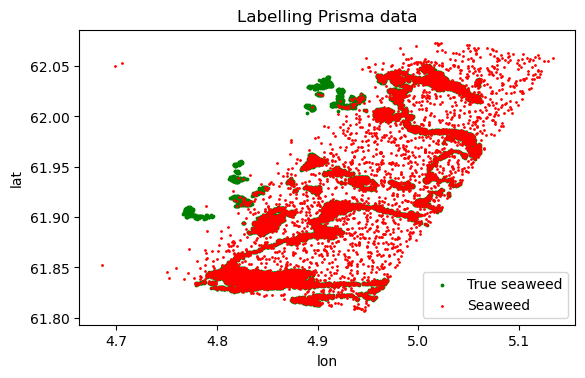

In [615]:
fig, ax = plt.subplots()
#df_no_seaweed.plot(ax = ax, color = "blue", label = "no seaweed")
df_true_seaweed.plot(ax = ax, color = "green", label = "True seaweed", markersize = 3)
df_seaweed.plot(ax = ax, color = "red", label = "Seaweed", markersize = 1)
#df_correct_prediction.plot(ax = ax, color = "red", label = "Correct prediction", markersize = 1)

ax.set_title("Labelling Prisma data")
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.legend()